In [26]:
import sys
import os
import sqlite3
import pandas as pd
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime

# Install mlflow if not already installed
%pip install mlflow
import mlflow

%pip install optuna
import optuna


# Suggestion on fixed folder structure
'''
/
/scripts        # scripts contains all .py,≈ ipynb files/modules
/scripts/[sub processing modules] # optionally used sub folders for processing modules
/data
/data/sqlite   #contains sqlite database .db
/data/csv     #contains temporary csv files used for scraping
'''


# Adding flag for using with Google Drive or run locally
use_gdrive = False

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')
  root_folder = '/content/drive/MyDrive/'
  print('Using gDrive')
  print(root_folder)
else:
  root_folder = os.getcwd()
  print('Not using gDrive')
  print(root_folder)

# Read config
config = yaml.safe_load(open('../src/scrape_ufc_stats_config.yaml'))

#set folder locations or override config
base_folder = '../'
db_location = base_folder+'data/sqlite_db/sqlite_scrapper.db'
scripts_folder = base_folder+'src'
local_run = False
db_conn = sqlite3.connect(db_location)
cursor = db_conn.cursor()

82141.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


82147.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Not using gDrive
/Users/evankellener/Desktop/UFC_fight_predictor/src


# Setting Up Proper Directory

In [27]:
sys.path.insert(0, '../')
print(sys.path)

['../', '../', '../', '../', '../', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/evankellener/Desktop/UFC_fight_predictor/ufc_env/lib/python3.9/site-packages']


In [28]:
os.chdir(scripts_folder)

# Scraping Process

In [ ]:
from scrapper_modules import Eventdetails, Fightdetails, Fightresultsandstats, Fighterdetails, Fightertott
from tqdm.notebook import tqdm_notebook

### Runtime: 0.8s

In [ ]:
ed = Eventdetails(config, db_conn)
#ed_df = ed.process()
ed_df = ed.process()#%Y-%m-%d
ed.save()
db_conn.commit()

### Runtime: 5m 24.2s

In [ ]:
fd = Fightdetails(config, db_conn, list(ed_df['URL']))
fd_df = fd.process()
fd.save()
db_conn.commit()

In [ ]:
frs = Fightresultsandstats(config, db_conn, list(fd_df['URL']))
fr_df, fs_df = frs.process()
frs.save()
db_conn.commit()

In [ ]:
fs_df = pd.read_csv(base_folder+'data/tmp/Fightstats.csv')

In [ ]:
print(fs_df.columns)

In [ ]:
frd = Fighterdetails(config, db_conn)
frd_df = frd.process(filtered_data=fs_df)
frd.save()
db_conn.commit()

Filter Of

In [ ]:
ft = Fightertott(config, db_conn, list(frd_df['URL']))
ft_df = ft.process()
ft_df = ft.save()
db_conn.commit()

In [ ]:
os.chdir(scripts_folder)

## Save Tabels to CSV

In [ ]:
import csv
def save_table_to_csv(db_path, table_name, csv_file_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    try:
        # Query to fetch all rows from the table
        cursor.execute(f"SELECT * FROM {table_name}")
        
        rows = cursor.fetchall()

        # Get column names
        column_names = [description[0] for description in cursor.description]

        # Write to CSV file
        with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(column_names)  # Write header
            writer.writerows(rows)        # Write data

        print(f"Table '{table_name}' has been saved to '{csv_file_path}'.")
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
    finally:
        connection.close()

In [ ]:
print(config['event_details_file_name'])
save_table_to_csv(db_location, 'ufc_event_details', base_folder+'data/tmp/ufc_event_details.csv.csv')
save_table_to_csv(db_location, 'ufc_fight_details', base_folder+'data/tmp/Fightdetails.csv')
save_table_to_csv(db_location, 'ufc_fight_results', base_folder+'data/tmp/Fightresults.csv')
save_table_to_csv(db_location, 'ufc_fight_stats', base_folder+'data/tmp/Fightstats.csv')
save_table_to_csv(db_location, 'ufc_fighter_details', base_folder+'data/tmp/Fighterdetails.csv')
save_table_to_csv(db_location, 'ufc_fighter_tott', base_folder+'data/tmp/Fightertott.csv')

In [ ]:
save_table_to_csv(db_location, 'ufc_fight_stats', base_folder+'data/tmp/Fightstats.csv')

# Height Weight Reach Modeling

In [ ]:
import height_weight_reach

In [ ]:
table_name = "ufc_fighter_tott"
predictor = height_weight_reach.hwr_process(db_location, table_name)

### Reach Predictor

In [ ]:
reach_model, reach_mse, reach_r2 = predictor.train_model(['HEIGHT', 'WEIGHT'], 'REACH')
print(f"Reach Model - MSE: {reach_mse}, R^2: {reach_r2}")

### Height Predictor

In [ ]:
height_weights, height_mse, height_r2 = predictor.train_model(['WEIGHT'], 'HEIGHT')
print(f"Height Model - MSE: {height_mse}, R^2: {height_r2}")


In [ ]:
updated_data = predictor.predict_missing_values(['HEIGHT', 'WEIGHT'], 'REACH')

In [ ]:
# Save updated data to database
updated_data.to_sql(os.path.splitext(config['fighter_tott_file_name'])[0], db_conn, if_exists='replace', index=False)

In [ ]:
missing_dob = updated_data[updated_data['DOB'].isnull()]
missing_dob.to_csv(base_folder+'data/tmp/final_data_with_no_dob.csv', index=False)

# Dob Scrapper

In [ ]:
import dob_scrapper

In [ ]:
scraper = dob_scrapper.DOBScraper()

In [ ]:
unfinished_fighter_data = pd.read_csv(base_folder+'data/tmp/final_data_with_no_dob.csv')
for index, row in tqdm_notebook(unfinished_fighter_data.iterrows(), total=unfinished_fighter_data.shape[0]):
    dob = scraper.scrape_dob(row['FIGHTER'])
    print(f"{row['FIGHTER']} - DOB: {dob}")
    unfinished_fighter_data.at[index, 'DOB'] = dob

unfinished_fighter_data.to_csv(base_folder+'data/tmp/final_data_with_dob.csv', index=False)

# SQL Queries

In [ ]:
with open('../src/sql_scripts/reset.sql', 'r') as f:
  sql_weight_fix_script = f.read()

cursor.executescript(sql_weight_fix_script)

### Weight Class Indexing

In [ ]:
with open('../src/sql_scripts/ufc_sql_weightclass.sql', 'r') as f:
  sql_weight_fix_script = f.read()

cursor.executescript(sql_weight_fix_script)

### Match Stats

# Change catch weight and open weight bouts in fight results

In [ ]:
with open('../src/sql_scripts/ufc_sql_match_stats.sql', 'r') as f:
  sql_match_stats = f.read()

cursor.executescript(sql_match_stats)

db_conn.commit()

In [ ]:
with open('../src/sql_scripts/ufc_sql_final_views.sql', 'r') as f:
  sql_final_views = f.read()

cursor.executescript(sql_final_views)
db_conn.commit()

In [ ]:
with open('../src/sql_scripts/test.sql', 'r') as f:
  sql_final_views = f.read()

cursor.executescript(sql_final_views)
db_conn.commit()

In [ ]:
# just display the rows where the jsfighter is 'RaulRosasJr.'
df[df['jfs_fighter'] == 'RaulRosasJr.']

In [ ]:
import pandas as pd
df = pd.read_sql_query("SELECT * from pre_final", db_conn)

In [ ]:
df.head(10)

In [ ]:
df.to_csv('../data/tmp/pre_final.csv', index=True)

In [ ]:
!ls

In [ ]:
df.head()

In [ ]:
import cleanup_class

cleaner = cleanup_class.Cleanup(df)
cleaner.order_by_date()
#interleaved_df = cleaner.duplicate_and_swap_row()
interleaved_df = cleaner.results_column()

In [ ]:
interleaved_df.to_csv('../data/tmp/interleaved_clean.csv', index=True)

In [ ]:
interleaved_df.head(10)

In [ ]:
from elo_class_fixed import FightDataProcessor, EnhancedElo

In [ ]:

# Add WINNER column from existing `result` column if it's present
if 'result' in interleaved_df.columns:
    interleaved_df['WINNER'] = interleaved_df.apply(
        lambda row: row['FIGHTER'] if row['result'] == 1 else row['opp_FIGHTER'], axis=1
    )

interleaved_df.to_csv('../data/tmp/interleaved_clean.csv', index=False)

In [ ]:
processor = FightDataProcessor('../data/tmp/interleaved_clean.csv')
raw_data = processor.load_data()
raw_data.to_csv('../data/tmp/interleaved_raw.csv')
cleaned_data = processor.clean_data()
cleaned_data.to_csv('../data/tmp/interleaved_cleaned.csv')

elo_calculator = EnhancedElo(k_factor=40)
results_with_elo = elo_calculator.process_fights(cleaned_data)
results_with_elo.to_csv('../data/tmp/interleaved_with_elo.csv')

print(results_with_elo.head())


# Confirm precomp postcomp 

In [ ]:
data = pd.read_csv('../data/tmp/interleaved_with_elo.csv')

In [ ]:
from elo_feature_enhancer import EloFeatureEnhancer

editor = EloFeatureEnhancer('../data/tmp/interleaved_with_elo.csv')

#arrage elo features in the proper place
ordered_data = editor.insert_elo_features_in_order()

ordered_data.to_csv('../data/tmp/ordered.csv')

# Confirm precomp postcomp - Store fighter's most recent postcomp stats
# and check consistency between precomp and previous postcomp values
editor.verify_precomp_postcomp_consistency()
editor.store_fighter_postcomp_stats()

filtered_data = editor.filter_by_fight_count(min_fights=1)
filtered_data.to_csv('../data/tmp/filtered.csv')

swapped_data = editor.duplicate_and_swap_rows()

for col in swapped_data.columns:
    swapped_data[col] = pd.to_numeric(swapped_data[col], errors='ignore')

float_cols = swapped_data.select_dtypes(include=['float64', 'float32']).columns

swapped_data[float_cols] = swapped_data[float_cols].applymap(lambda x: round(x, 2) if pd.notnull(x) else x)

if 'DATE' in swapped_data.columns:
    swapped_data['DATE'] = pd.to_datetime(swapped_data['DATE'], errors='coerce').dt.strftime('%Y-%m-%d')

swapped_data.to_csv('../data/tmp/final.csv', index=False, float_format='%.2f')

In [ ]:
from sanity_check import SanityCheck
success, results = SanityCheck('../data/tmp/final.csv', 'Alexandre Pantoja')

if success:
        print("\nSANITY CHECK PASSED: All postcomp stats match the precomp stats in subsequent fights.")
else:
    print("\nSANITY CHECK FAILED: Some stats don't match between fights.")

In [ ]:
elo_calculator.query_fighter_elo('Ian Machado Garry')

In [ ]:
elo_calculator.top_k_fighters(50)

# Predictions/Models

In [29]:
from model import DNNFightPredictor

predictor = DNNFightPredictor(file_path = '../data/tmp/final.csv')

Most recent date in dataset: 2025-03-29 00:00:00
Training cutoff date: 2024-03-29 00:00:00
Using data from 2009-01-01 to 2024-03-29 00:00:00 for training
Using data from 2024-03-29 00:00:00 to 2025-03-29 00:00:00 for testing
Training set size: 11066
Testing set size: 788
Saved feature scaler to /Users/evankellener/Desktop/UFC_fight_predictor/saved_models/feature_scaler.joblib


In [ ]:
predictor.hyperparameter_tuning()

In [ ]:
predictor.evaluate_generalization()

Loaded stored postcomp stats for 1813 fighters
Loaded weightclass lookup table with 12 entries
Created weightclass lookup dictionary



Using saved best model loaded from /Users/evankellener/Desktop/UFC_fight_predictor/saved_models/best_model.h5 for generalization evaluation with postcomp values
Test set size: 788 fights
Loading saved scaler from /Users/evankellener/Desktop/UFC_fight_predictor/saved_models/feature_scaler.joblib
Processed 740 test fights (used stored stats for 632 fights, skipped 48 with no data)

========== Generalization Performance with Postcomp Values ==========
Test accuracy: 0.5892
Precision: 0.5947
Recall: 0.7772
F1-score: 0.6738
AUC-ROC: 0.6045

Confusion Matrix:
TN: 122 | FP: 214
FN: 90 | TP: 314
Positive Predictive Value: 0.5947
Negative Predictive Value: 0.5755

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.36      0.45       336
           1       0.59      0.78      0.67       404

    accuracy                           0.59       740
   macro avg       0.59      0.57      0.56       740
weighted avg       0.59      0.

ROC curve saved to /Users/evankellener/Desktop/UFC_fight_predictor/postcomp_roc_curve.png

Using saved best model loaded from /Users/evankellener/Desktop/UFC_fight_predictor/saved_models/best_model.h5 for generalization evaluation
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7491 - loss: 0.5695  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

========== Generalization Performance ==========
Test accuracy: 0.7462
Test loss: 0.5724
Precision: 0.7457
Recall: 0.8116
F1-score: 0.7773
AUC-ROC: 0.8127

Confusion Matrix:
TN: 239 | FP: 119
FN: 81 | TP: 349
Positive Predictive Value: 0.7457
Negative Predictive Value: 0.7469

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       358
           1       0.75      0.81      0.78       430

    accuracy                           0.75       788
   macro avg       0.75      0.74      0.74       788
weighted avg       0.75      0.75      0.74       788


Metrics by Mont

{'accuracy': 0.5891891891891892,
 'precision': 0.5946969696969697,
 'recall': 0.7772277227722773,
 'f1': 0.6738197424892703,
 'auc_roc': np.float64(0.6044834394153702)}

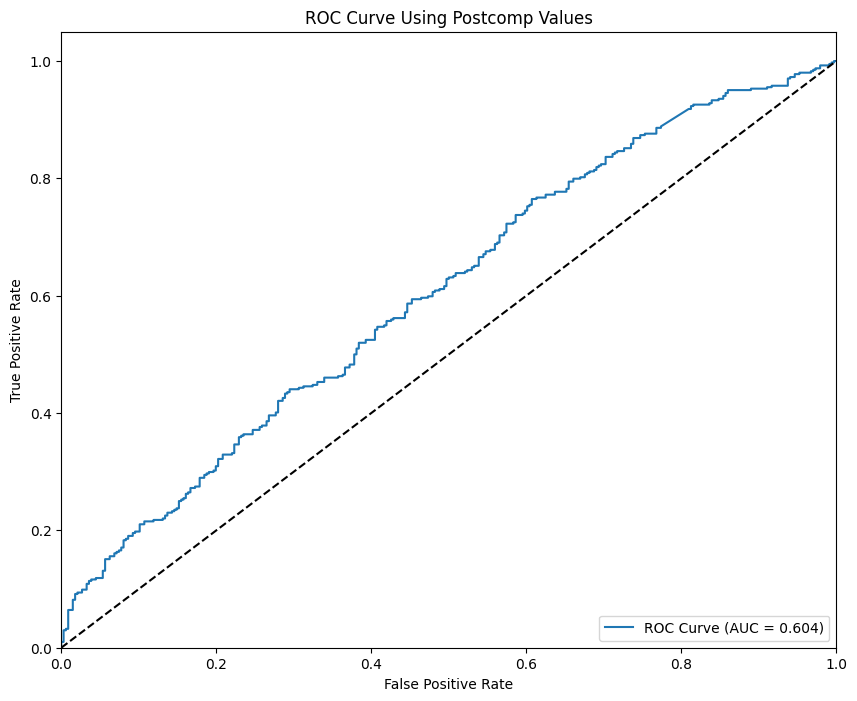

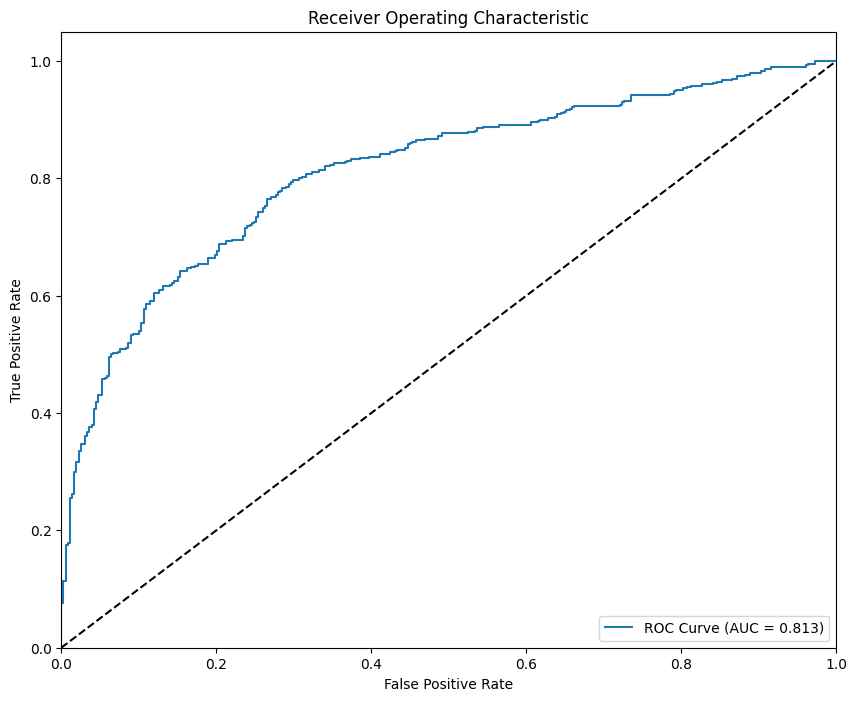

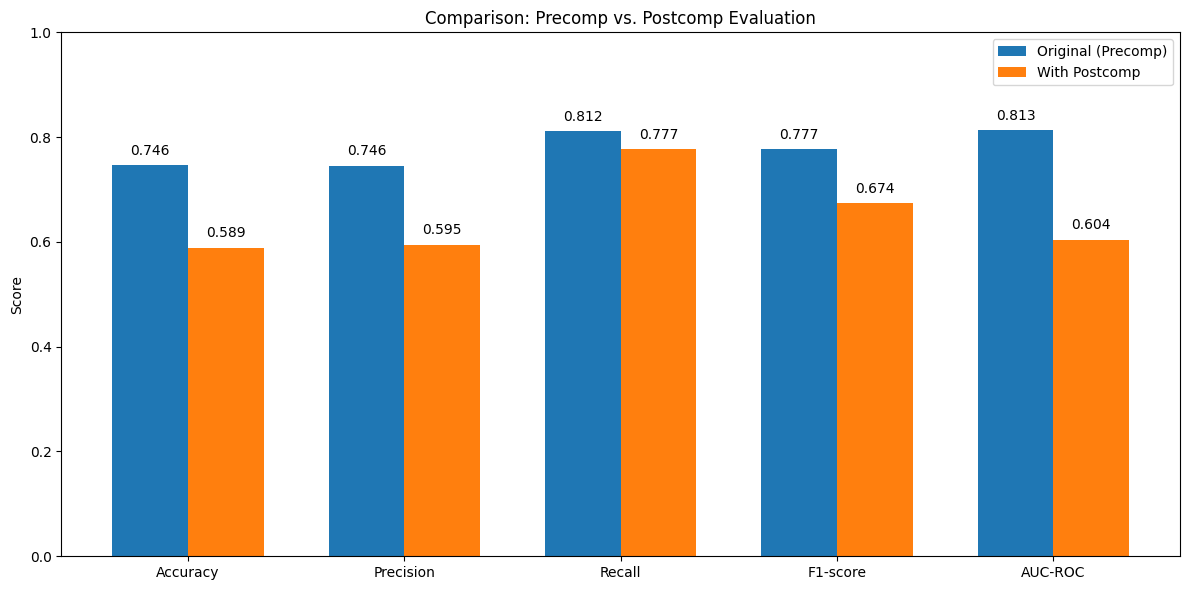

In [35]:
predictor.evaluate_generalization_with_postcomp()

In [ ]:
#export fighter data
pre_final_data = pd.read_csv('../data/tmp/pre_final.csv')
filtered_pf = pre_final_data[pre_final_data['FIGHTER'] == 'Alexandre Pantoja']

In [ ]:
filtered_pf.to_csv('../data/tmp/fighter_filtered_final.csv')

In [ ]:
predictor.predict_with_postcomp_data('Alex Pereira', 'Magomed Ankalaev', weight1=205, weight2=205)
predictor.predict_with_postcomp_data('Justin Gaethje', 'Rafael Fiziev', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('Jalin Turner', 'Ignacio Bahamondes', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('King Green', 'Mauricio Ruffy', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('Joshua Van', 'Rei Tsuruya', weight1=125, weight2=125)
predictor.predict_with_postcomp_data('Bruno Fe', 'Rei Tsuruya', weight1=125, weight2=125)

# Predict Kape vs Almabayev

In [ ]:
predictor.mlflow_run()

In [ ]:
predictor = DNNFightPredictor(file_path = '../data/tmp/interleaved_results_elo_hist_1_removed.csv')
predictor.hyperparameter_tuning()

# Elo Comparisson
* old data + elo columns(2) = 0.664

{'learning_rate': 2.661075089731784e-05,
 'batch_size': 64,
 'dropout_rate': 0.4113464221107168,
 'l2_reg': 0.0067498143500825235,
 'layer_size_0': 64,
 'layer_size_1': 48,
 'layer_size_2': 32,
 'layer_size_3': 112}

* new data + elo columns(2) = 0.666




In [ ]:
predictor.shap_analysis()

In [ ]:
predictor.predict_fight_winner('Merab Dvalishvili', 'Umar Nurmagomedov')

# Best Hyperparameters for elo columns

{'learning_rate': 0.001441126615791276,
 'batch_size': 64,
 'dropout_rate': 0.35954714170732943,
 'l2_reg': 0.0030518395936230975,
 'layer_size_0': 80,
 'layer_size_1': 32}

selected_features = [
            'age', 'HEIGHT', 'WEIGHT', 'REACH', 'weightindex', 
            'precomp_sigstr_pm', 'precomp_tdavg', 'precomp_sapm', 'precomp_subavg',
            'precomp_tddef', 'precomp_sigstr_perc', 'precomp_strdef', 'precomp_tdacc_perc',
            'precomp_totalacc_perc', 'precomp_headacc_perc', 'precomp_bodyacc_perc', 'precomp_legacc_perc',
            'precomp_distacc_perc','precomp_clinchacc_perc','precomp_groundacc_perc','precomp_winsum', 'precomp_losssum',
            'precomp_sigstr_pm3', 'precomp_tdavg3', 'precomp_sapm3', 'precomp_subavg3',
            'precomp_tddef3', 'precomp_sigstr_perc3', 'precomp_strdef3', 'precomp_tdacc_perc3',
            'precomp_totalacc_perc3', 'precomp_headacc_perc3', 'precomp_bodyacc_perc3', 'precomp_legacc_perc3',
            'precomp_distacc_perc3','precomp_clinchacc_perc3','precomp_groundacc_perc3',
            'precomp_winsum3', 'precomp_losssum3',
            'precomp_sigstr_pm5', 'precomp_tdavg5', 'precomp_sapm5', 'precomp_subavg5',
            'precomp_tddef5', 'precomp_sigstr_perc5', 'precomp_strdef5', 'precomp_tdacc_perc5',
            'precomp_totalacc_perc5', 'precomp_headacc_perc5', 'precomp_bodyacc_perc5', 'precomp_legacc_perc5',
            'precomp_distacc_perc5','precomp_clinchacc_perc5','precomp_groundacc_perc5',
            'precomp_winsum5', 'precomp_losssum5',
            'precomp_elo','elo_diff_pre', 'precomp_elo_change_3', 'precomp_elo_change_5', 
            'opp_age', 'opp_HEIGHT', 'opp_WEIGHT', 'opp_REACH','opp_weightindex',
            'opp_precomp_sigstr_pm', 'opp_precomp_tdavg', 'opp_precomp_sapm', 'opp_precomp_subavg',
            'opp_precomp_tddef', 'opp_precomp_sigstr_perc', 'opp_precomp_strdef', 'opp_precomp_tdacc_perc',
            'opp_precomp_totalacc_perc', 'opp_precomp_headacc_perc','opp_precomp_bodyacc_perc','opp_precomp_legacc_perc',
            'opp_precomp_distacc_perc','opp_precomp_clinchacc_perc','opp_precomp_groundacc_perc','opp_precomp_winsum', 'opp_precomp_losssum',
            'opp_precomp_sigstr_pm3', 'opp_precomp_tdavg3', 'opp_precomp_sapm3', 'opp_precomp_subavg3',
            'opp_precomp_tddef3', 'opp_precomp_sigstr_perc3', 'opp_precomp_strdef3', 'opp_precomp_tdacc_perc3',
            'opp_precomp_totalacc_perc3', 'opp_precomp_headacc_perc3','opp_precomp_bodyacc_perc3','opp_precomp_legacc_perc3',
            'opp_precomp_distacc_perc3','opp_precomp_clinchacc_perc3','opp_precomp_groundacc_perc3',
            'opp_precomp_winsum3', 'opp_precomp_losssum3','opp_weight_avg3',
            'opp_precomp_elo','opp_elo_diff_pre', 'opp_precomp_elo_change_3', 'opp_precomp_elo_change_5',
            'opp_precomp_sigstr_pm5', 'opp_precomp_tdavg5', 'opp_precomp_sapm5', 'opp_precomp_subavg5',
            'opp_precomp_tddef5', 'opp_precomp_sigstr_perc5', 'opp_precomp_strdef5', 'opp_precomp_tdacc_perc5',
            'opp_precomp_totalacc_perc5', 'opp_precomp_headacc_perc5','opp_precomp_bodyacc_perc5','opp_precomp_legacc_perc5',
            'opp_precomp_distacc_perc5','opp_precomp_clinchacc_perc5','opp_precomp_groundacc_perc5',
            'opp_precomp_winsum5', 'opp_precomp_losssum5','opp_precomp_elo_change_5',
        ]



        {'learning_rate': 0.0004982871706745808,
 'batch_size': 16,
 'dropout_rate': 0.4512401787251757,
 'l2_reg': 0.0005124681578208401,
 'layer_size_0': 128,
 'layer_size_1': 80,
 'layer_size_2': 64,
 'layer_size_3': 32}

In [ ]:
import pandas as pd

# Creating the data for the CSV file
data = [
    ["Song Yadong", "Henry Cejudo", "Song Yadong"],
    ["Anthony Hernandez", "Brendan Allen", "Anthony Hernandez"],
    ["Rob Font", "Jean Matsumoto", "Rob Font"],
    ["Jean Silva", "Melsik Baghdasaryan", "Jean Silva"],
    ["Alonzo Menifield", "Julius Walker", "Alonzo Menifield"],
    ["Ion Cuțelaba", "Ibo Aslan", "Ion Cuțelaba"],
    ["Melquizael Costa", "Andre Fili", "Melquizael Costa"],
    ["Mansur Abdul-Malik", "Nick Klein", "Mansur Abdul-Malik"],
    ["Ricky Simón", "Javid Basharat", "Ricky Simón"],
    ["Austin Vanderford", "Nikolay Veretennikov", "Austin Vanderford"],
    ["Nursulton Ruziboev", "Eric McConico", "Nursulton Ruziboev"],
    ["Modestas Bukauskas", "Raffael Cerqueira", "Modestas Bukauskas"],
    ["Manel Kape", "Asu Almabayev", "Manel Kape"],
    ["Cody Brundage", "Julian Marquez", "Cody Brundage"],
    ["Nasrat Haqparast", "Esteban Ribovics", "Nasrat Haqparast"],
    ["Hyder Amil", "William Gomis", "Hyder Amil"],
    ["Sam Patterson", "Danny Barlow", "Sam Patterson"],
    ["Mário Pinto", "Austen Lane", "Mário Pinto"],
    ["Chepe Mariscal", "Ricardo Ramos", "Chepe Mariscal"],
    ["Danny Silva", "Lucas Almeida", "Danny Silva"],
    ["JJ Aldrich", "Andrea Lee", "JJ Aldrich"],
    ["Ramazan Temirov", "Charles Johnson", "Ramazan Temirov"]
]

# Creating a DataFrame
df = pd.DataFrame(data, columns=["Fighter A", "Fighter B", "Winner"])

# Exporting the DataFrame to a CSV file
file_path = "../data/tmp/UFC_Fight_Night_Results.csv"
df.to_csv(file_path, index=False)

# Providing the file to the user
file_path
